In [32]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import log_loss

# Dataset representation #

A telecommunications dataset will be used for predicting customer churn. This is a historical customer dataset where each row represents one customer. The data is relatively easy to understand. Typically it is less expensive to keep customers than acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company.

### The dataset includes information about: ###

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they had been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

In [2]:
!wget -O ChurnData.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv

--2024-05-04 17:08:12--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35943 (35K) [text/csv]
Saving to: ‘ChurnData.csv’

ChurnData.csv       100%[===================>]  35.10K   210KB/s    in 0.2s    

2024-05-04 17:08:14 (210 KB/s) - ‘ChurnData.csv’ saved [35943/35943]



In [9]:
churn_df = pd.read_csv("ChurnData.csv")
churn_df.info()
churn_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    200 non-null    float64
 1   age       200 non-null    float64
 2   address   200 non-null    float64
 3   income    200 non-null    float64
 4   ed        200 non-null    float64
 5   employ    200 non-null    float64
 6   equip     200 non-null    float64
 7   callcard  200 non-null    float64
 8   wireless  200 non-null    float64
 9   longmon   200 non-null    float64
 10  tollmon   200 non-null    float64
 11  equipmon  200 non-null    float64
 12  cardmon   200 non-null    float64
 13  wiremon   200 non-null    float64
 14  longten   200 non-null    float64
 15  tollten   200 non-null    float64
 16  cardten   200 non-null    float64
 17  voice     200 non-null    float64
 18  pager     200 non-null    float64
 19  internet  200 non-null    float64
 20  callwait  200 non-null    float6

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


In [10]:
churn_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
churn_df.info()
churn_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    200 non-null    float64
 1   age       200 non-null    float64
 2   address   200 non-null    float64
 3   income    200 non-null    float64
 4   ed        200 non-null    float64
 5   employ    200 non-null    float64
 6   equip     200 non-null    float64
 7   callcard  200 non-null    float64
 8   wireless  200 non-null    float64
 9   churn     200 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 15.8 KB


,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


In [12]:
print('total columns: ', churn_df.shape[1])
print('total rows: ', churn_df.shape[0])

total columns:  10
total rows:  200


In [13]:
X = np.asarray(churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']])
X[0:5]

array([[ 11.,  33.,   7., 136.,   5.,   5.,   0.],
       [ 33.,  33.,  12.,  33.,   2.,   0.,   0.],
       [ 23.,  30.,   9.,  30.,   1.,   2.,   0.],
       [ 38.,  35.,   5.,  76.,   2.,  10.,   1.],
       [  7.,  35.,  14.,  80.,   2.,  15.,   0.]])

### Normalizing data:

In [14]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-1.13518441, -0.62595491, -0.4588971 ,  0.4751423 ,  1.6961288 ,
        -0.58477841, -0.85972695],
       [-0.11604313, -0.62595491,  0.03454064, -0.32886061, -0.6433592 ,
        -1.14437497, -0.85972695],
       [-0.57928917, -0.85594447, -0.261522  , -0.35227817, -1.42318853,
        -0.92053635, -0.85972695],
       [ 0.11557989, -0.47262854, -0.65627219,  0.00679109, -0.6433592 ,
        -0.02518185,  1.16316   ],
       [-1.32048283, -0.47262854,  0.23191574,  0.03801451, -0.6433592 ,
         0.53441472, -0.85972695]])

In [15]:
y = np.asarray(churn_df['churn'])
y [0:5]

array([1, 1, 0, 0, 0])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (160, 7) (160,)
Test set: (40, 7) (40,)


In [21]:
# smaller C value -> stronger regularization
# solver specifies the algorithm to use
# 'liblinear' is good for small datasets
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)

In [22]:
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

### predict_proba returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 0, P(Y=0|X), and second column is probability of class 1, P(Y=1|X):

In [23]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.54132919, 0.45867081],
       [0.60593357, 0.39406643],
       [0.56277713, 0.43722287],
       [0.63432489, 0.36567511],
       [0.56431839, 0.43568161],
       [0.55386646, 0.44613354],
       [0.52237207, 0.47762793],
       [0.60514349, 0.39485651],
       [0.41069572, 0.58930428],
       [0.6333873 , 0.3666127 ],
       [0.58068791, 0.41931209],
       [0.62768628, 0.37231372],
       [0.47559883, 0.52440117],
       [0.4267593 , 0.5732407 ],
       [0.66172417, 0.33827583],
       [0.55092315, 0.44907685],
       [0.51749946, 0.48250054],
       [0.485743  , 0.514257  ],
       [0.49011451, 0.50988549],
       [0.52423349, 0.47576651],
       [0.61619519, 0.38380481],
       [0.52696302, 0.47303698],
       [0.63957168, 0.36042832],
       [0.52205164, 0.47794836],
       [0.50572852, 0.49427148],
       [0.70706202, 0.29293798],
       [0.55266286, 0.44733714],
       [0.52271594, 0.47728406],
       [0.51638863, 0.48361137],
       [0.71331391, 0.28668609],
       [0.

## Evaluation

### **1. Jaccard index:** we define jaccard as the size of the intersection divided by the size of the union of the two label sets. If the entire set of predicted labels for a sample strictly matches with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.

In [25]:
jaccard_score(y_test, yhat,pos_label=0)

0.7058823529411765

### **2. Confusion matrix:**

In [27]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confutsion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 6  9]
 [ 1 24]]


Confusion matrix, without normalization
[[ 6  9]
 [ 1 24]]


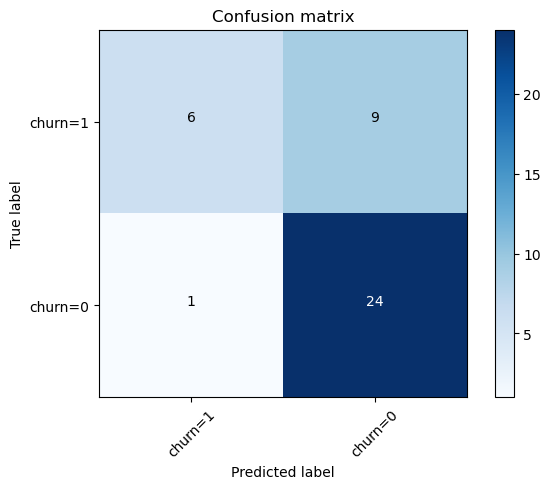

In [30]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [31]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.73      0.96      0.83        25
           1       0.86      0.40      0.55        15

    accuracy                           0.75        40
   macro avg       0.79      0.68      0.69        40
weighted avg       0.78      0.75      0.72        40



In [33]:
log_loss(y_test, yhat_prob)

0.6017092478101185

In [46]:
LR_new = LogisticRegression(C=0.1, solver='lbfgs').fit(X_train, y_train)
yhat_new = LR_new.predict(X_test)
yhat_prob_new = LR_new.predict_proba(X_test)
print(yhat_new)
print(yhat_prob_new)

[0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0]
[[0.73 0.27]
 [0.88 0.12]
 [0.8  0.2 ]
 [0.9  0.1 ]
 [0.8  0.2 ]
 [0.73 0.27]
 [0.73 0.27]
 [0.87 0.13]
 [0.36 0.64]
 [0.91 0.09]
 [0.81 0.19]
 [0.87 0.13]
 [0.59 0.41]
 [0.41 0.59]
 [0.9  0.1 ]
 [0.69 0.31]
 [0.65 0.35]
 [0.66 0.34]
 [0.63 0.37]
 [0.73 0.27]
 [0.88 0.12]
 [0.67 0.33]
 [0.92 0.08]
 [0.62 0.38]
 [0.64 0.36]
 [0.95 0.05]
 [0.67 0.33]
 [0.68 0.32]
 [0.7  0.3 ]
 [0.96 0.04]
 [0.93 0.07]
 [0.71 0.29]
 [0.39 0.61]
 [0.95 0.05]
 [0.88 0.12]
 [0.87 0.13]
 [0.33 0.67]
 [0.69 0.31]
 [0.91 0.09]
 [0.7  0.3 ]]


In [47]:
jaccard_score(y_test, yhat_new,pos_label=0)

0.6944444444444444

Confusion matrix, without normalization
[[ 4 11]
 [ 0 25]]


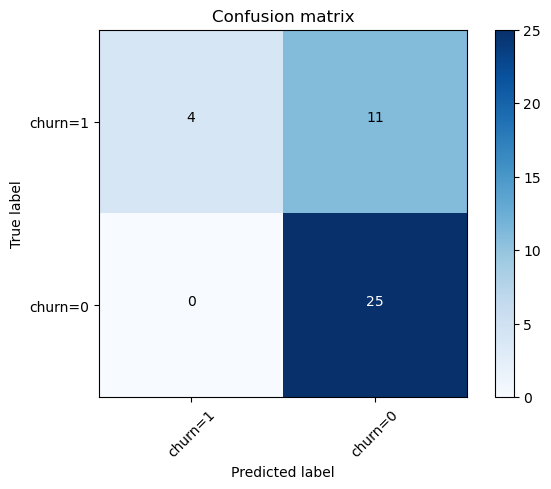

In [48]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_new, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [49]:
print (classification_report(y_test, yhat_new))

              precision    recall  f1-score   support

           0       0.69      1.00      0.82        25
           1       1.00      0.27      0.42        15

    accuracy                           0.73        40
   macro avg       0.85      0.63      0.62        40
weighted avg       0.81      0.72      0.67        40

